đầu vào 512x512 
- skimage.util.random_noise add nhiễu
- Chia ảnh các khối 8x8
- Thực hiện biến đổi dct (scipy)
- Làm với nhiễu gauss, 3 * sigma (thử với các loại nhiễu khác) (lọc theo thr: np.where )
- Biến đổi ngược lại
- Hiển thị ảnh sau khi biến đổi
- Các độ đo

# Continute

## Gaussion

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util
from scipy.fftpack import dct, idct
import cv2

# Đọc ảnh và thêm nhiễu
image = cv2.cvtColor(cv2.imread('../uploads/lenna.png'), cv2.COLOR_BGR2RGB)

rows, cols, channels = image.shape
mean = 0
std_dev = 20  # Điều chỉnh độ lớn của nhiễu 

noise = np.random.normal(mean, std_dev, (rows, cols, channels)) # gauss
# noise = np.random.poisson(std_dev, (rows, cols, channels)) # poisson

# Thêm nhiễu vào ảnh
noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

w = 8 #modify it if you want, maximal 8 due to default quantization table is 8*8
h = w
xLen = image.shape[1]//w
yLen = image.shape[0]//h

def toBlocks(img):
  blocks = np.zeros((yLen,xLen,h,w,3),dtype=np.int16)
  for y in range(yLen):
    for x in range(xLen):
      blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w]
  return np.array(blocks)
blocks = toBlocks(noisy_image)



50.0


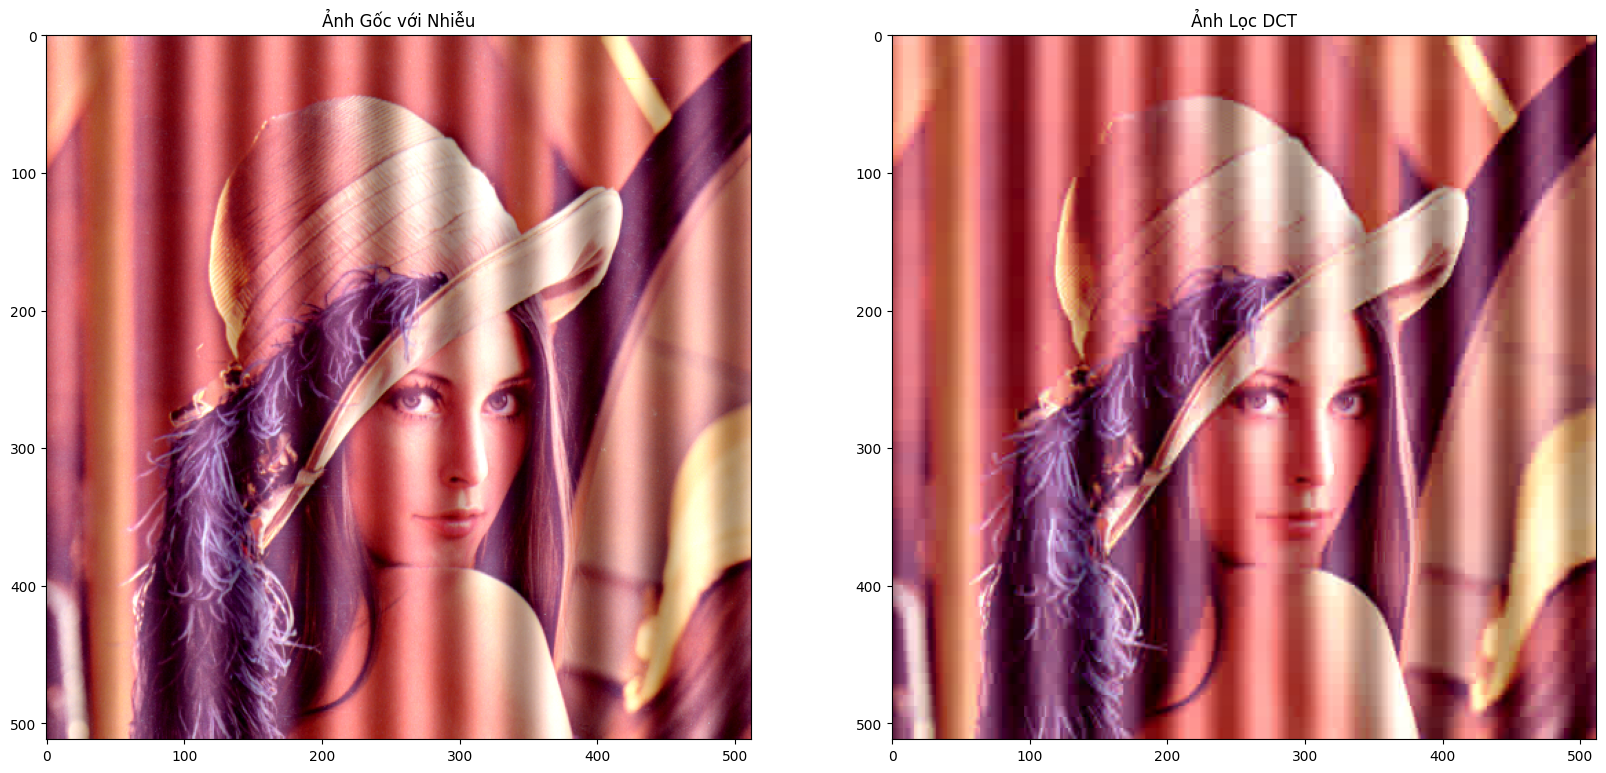

In [68]:
dct_blocks = dct(dct(blocks, axis=2, norm='ortho'), axis=3, norm='ortho')

threshold = std_dev * 2.5
print(threshold)
dct_blocks_filtered = np.where(np.abs(dct_blocks) < threshold, 0, dct_blocks)

filtered_blocks = idct(idct(dct_blocks_filtered, axis=2, norm='ortho'), axis=3, norm='ortho')
# filtered_blocks = idct(idct(dct_blocks_filtered, axis=3, norm='ortho'), axis=2, norm='ortho')


def blocks2img(blocks):
  W=xLen*w
  H=yLen*h
  img = np.zeros((H,W,3))
  for y in range(yLen):
    for x in range(xLen):
      img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x]
  return img
newImg=blocks2img(filtered_blocks)
# norm_image = cv2.normalize(newImg, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8SC3)
norm_image = np.clip(newImg, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image)
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(norm_image)
axes[1].set_title('Ảnh Lọc DCT')
plt.show()


## Periodic

https://matematicas.uam.es/~fernando.chamizo/dark/d_periodic.html

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util
from scipy.fftpack import dct, idct
import cv2

# Đọc ảnh và thêm nhiễu
image = cv2.imread('../uploads/goose.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('../uploads/lenna.png', cv2.IMREAD_GRAYSCALE)


x = np.linspace(0, 1,512) 
y = np.linspace(0, 1,512)

noise = np.array([0.25*np.cos(32*np.pi*x) * 255])
# noise = np.array([0.25*np.sin(10*np.pi*(x+y)) * 255])

# Thêm nhiễu vào ảnh
noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

w = image.shape[1] #modify it if you want, maximal 8 due to default quantization table is 8*8
h = w
xLen = image.shape[1]//w
yLen = image.shape[0]//h

- 3, 17

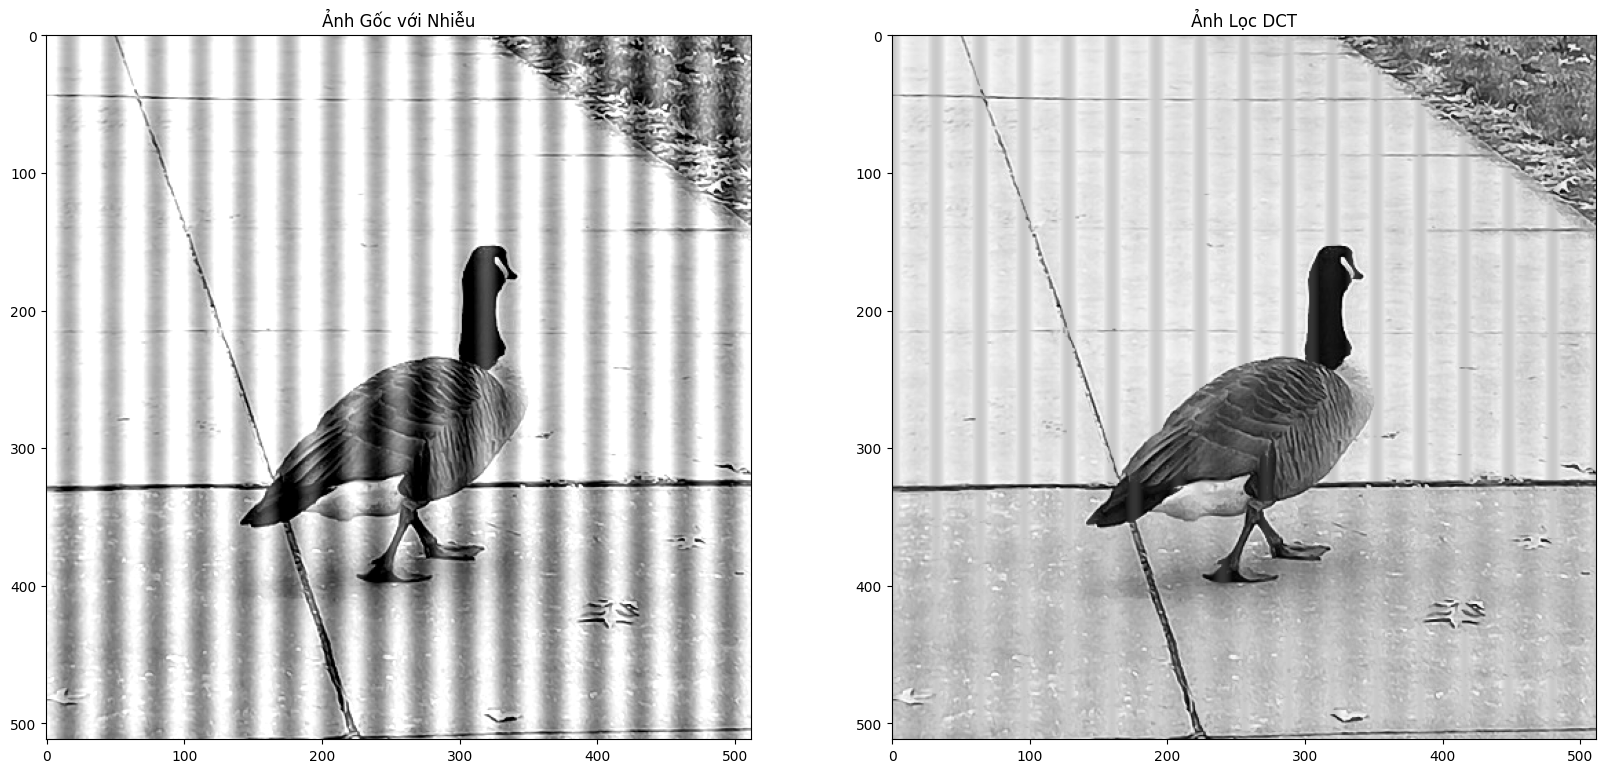

In [248]:
dct_blocks = dct(dct(noisy_image.T, norm='ortho').T, norm='ortho')

J = dct_blocks
AJ = np.abs(dct_blocks)

kernel_size = 5
alpha = 21.5
median_dct = cv2.medianBlur(AJ.astype(np.float32), kernel_size)
mask_noisy = AJ > alpha * median_dct

median_dct_noabs = cv2.medianBlur(J.astype(np.float32), kernel_size)
dct_blocks_filtered = dct_blocks.copy()
apply_mask = np.where(mask_noisy == True, median_dct_noabs, J)
dct_blocks_filtered = apply_mask

filtered_blocks = idct(idct(dct_blocks_filtered.T, norm='ortho').T, norm='ortho')

norm_image = np.clip(filtered_blocks, 0, 255).astype(np.uint8)
# norm_image = norm_image.astype(np.int16)

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(noisy_image, cmap='gray')
axes[0].set_title('Ảnh Gốc với Nhiễu')
axes[1].imshow(norm_image, cmap='gray')
axes[1].set_title('Ảnh Lọc DCT')
plt.show()

# Histogram

In [211]:
import plotly.express as px

In [249]:
counts, bins = np.histogram(noisy_image.ravel(), bins=range(0, 256, 1))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'pixel', 'y':'count'})
fig.show()

In [250]:
counts, bins = np.histogram(norm_image.ravel(), bins=range(0, 256, 1))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'pixel', 'y':'count'})
fig.show()